In [134]:
import numpy as np
import matplotlib.pyplot as plt


In [135]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

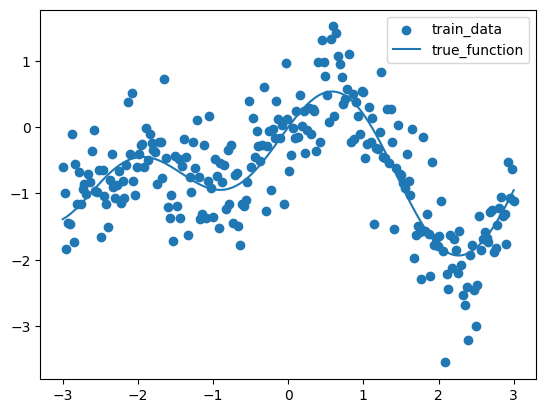

In [136]:
rng = np.random.default_rng(30)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [137]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [138]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [139]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

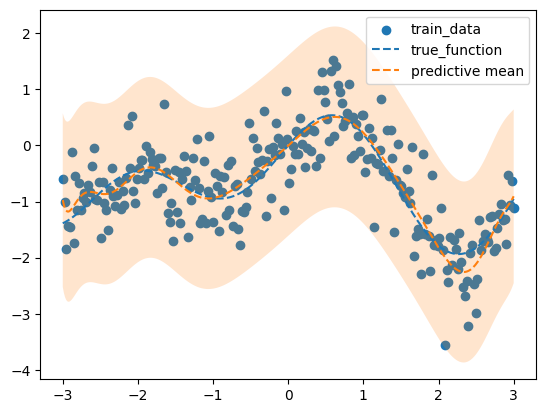

In [140]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [141]:
def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    
    n = X.shape[0]
    
    C = sigma**2 * (np.eye(n) + (1.0 / lamb) * (X @ X.T))

    C_inv = np.linalg.inv(C)
    sign, logdetC = np.linalg.slogdet(C)

    log_ev = -0.5 * (n * np.log(2 * np.pi) + logdetC + y.T @ C_inv @ y)
    return float(log_ev)

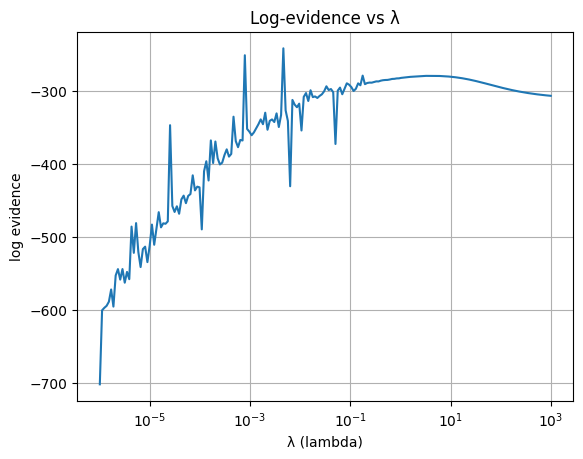

Optimal λ: 0.004605922041145108


In [142]:
lambdas = np.logspace(-6, 3, 200)
log_evidences = [log_evidence(l, X, y, sigma) for l in lambdas]
best_lambda = lambdas[np.argmax(log_evidences)]

plt.semilogx(lambdas, log_evidences)
plt.xlabel("λ (lambda)")
plt.ylabel("log evidence")
plt.title("Log-evidence vs λ")
plt.grid(True)
plt.show()

print("Optimal λ:", best_lambda)

In [143]:
def predict(X_train, y_train, X_test, alpha, lamb):
    M = X_train.shape[1]
    A = lamb * np.eye(M) + alpha * (X_train.T @ X_train)
    A_inv = np.linalg.inv(A)
    m_N = alpha * A_inv @ (X_train.T @ y_train)

    mean_pred = X_test @ m_N
    var_pred = 1.0 / alpha + np.sum(X_test @ A_inv @ X_test.T, axis=1)
    std_pred = np.sqrt(var_pred)
    return mean_pred, std_pred

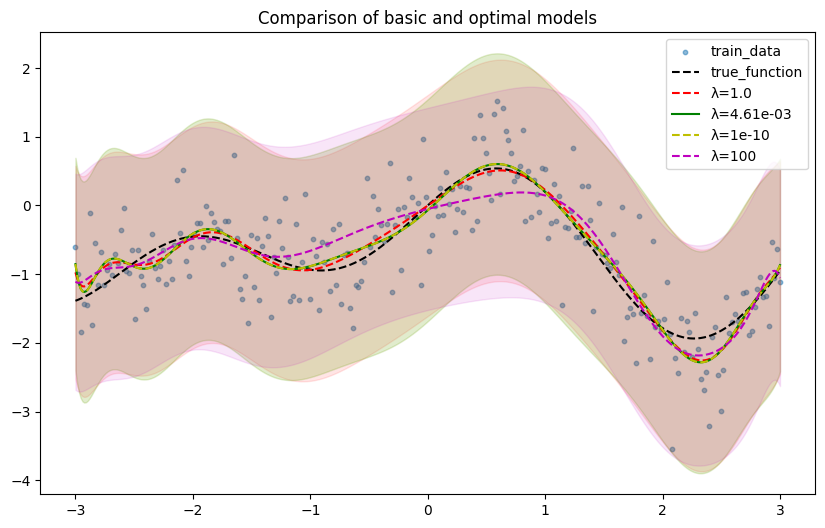

In [144]:
mean_base, std_base = predict(X, y, X_new, alpha, 1.0)
mean_best, std_best = predict(X, y, X_new, alpha, best_lambda)
mean_1, std_1 = predict(X, y, X_new, alpha, 1e-10)
mean_2, std_2 = predict(X, y, X_new, alpha, 100)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=10, alpha=0.5, label="train_data")
plt.plot(x_new, f_true(x_new), 'k--', label="true_function")

plt.plot(x_new, mean_base, 'r--', label=f"λ=1.0")
plt.fill_between(x_new, mean_base - 2*std_base, mean_base + 2*std_base, color='r', alpha=0.1)

plt.plot(x_new, mean_best, 'g-', label=f"λ={best_lambda:.2e}")
plt.fill_between(x_new, mean_best - 2*std_best, mean_best + 2*std_best, color='g', alpha=0.1)

plt.plot(x_new, mean_1, 'y--', label=f"λ=1e-10")
plt.fill_between(x_new, mean_1 - 2*std_1, mean_1 + 2*std_1, color='y', alpha=0.1)

plt.plot(x_new, mean_2, 'm--', label=f"λ=100")
plt.fill_between(x_new, mean_2 - 2*std_2, mean_2 + 2*std_2, color='m', alpha=0.1)

plt.legend()
plt.title("Comparison of basic and optimal models")
plt.show()

In [144]:
'''
вывод: оптимальная лямбда - компромисс между гибкостью и отсутствием переобучения
при большой лямбда приближение становится менее гибким и точным
при маленькой лямбде при данной функции заметны лишь небольшие отклонения от оптимальной, возможно, на более сложной изначальной функции лучше был бы виден эффект переобучения
'''